# EuroSat Image Classification using ResNeXt

Hector Becerra  
Juan Terven  
2023

**ResNeXt** is an advanced convolutional neural network (CNN) architecture that represents a natural evolution of the ResNet model, introduced by Saining Xie, Ross Girshick, Piotr Dollár, Zhuowen Tu, and Kaiming He in 2016. The key innovation of ResNeXt lies in its use of grouped convolutions, which are structured into modules called "cardinality" — the size of the set of transformations. This design allows ResNeXt to learn more complex representations with a given budget of parameters and computations, effectively increasing the model's capacity without a significant rise in complexity. By incorporating the concept of cardinality, ResNeXt provides a more efficient way to scale network width, delivering improved accuracy in image classification tasks with a manageable increase in computational demand. Its elegant balance between depth, width, and cardinality has made ResNeXt a popular choice for various computer vision applications.

In [1]:
import os
import numpy as np 
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import wandb
from torch.utils.data import DataLoader
import json
from torchvision.models import resnext50_32x4d,ResNeXt50_32X4D_Weights

from train_utils import get_predictions,compute_val_loss,EarlyStopping,train_model
from eval_utils import remove_wandb_hooks,evaluate_test_set,precision_recall_analysis
from EuroSAT import EurosatDataset,visualize_classes


In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")  
    print("Found GPU")
else:
    torch.device("cpu")
    
print("Pytorch version:", torch.__version__)

Found GPU
Pytorch version: 1.13.1+cu117


## Login to Wandb to log experiment

In [3]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'EuroSat_ResNeXt_Classifier.ipynb'

wandb.login()

wandb: Currently logged in as: jrterven. Use `wandb login --relogin` to force relogin


True

# Data
The [EuroSat Dataset](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8736785) consists of 27,000 labeled images with ten different land use and land cover classes. It is multi-spectral, covering 13 spectral bands in the visible, near infrared, and short wave infrared parts of the spectrum. The dataset is geo-referenced and based on openly and freely accessible earth observation data. The classes are the following.

| No. | Land Use Type           |
|-----|-------------------------|
| 1   | AnnualCrop              |
| 2   | Forest                  |
| 3   | HerbaceousVegatation    |
| 4   | Highway                 |
| 5   | Industrial              |
| 6   | Pasture                 |
| 7   | PermanentCrop           |
| 8   | Residential             |
| 9   | River                   |
| 10  | SeaLake                 |

In [3]:
data_path = "C:/Users/jrtervens/Documents/data/eurosat/EuroSAT/"

In [4]:
# Load the labels 
f = open(f"{data_path}label_map.json", "r")
label_to_index = json.load(f)

In [5]:
index_to_label = {label_to_index[k]:k for k in label_to_index}
print(index_to_label)

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


## Data Transformations

In [6]:
# Check the transformations used in the pre-trained model
weights = ResNeXt50_32X4D_Weights.DEFAULT
preprocess = weights.transforms()
print(preprocess)

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [7]:
# Define a sequence of transformations to be applied to images
transformToTensor = transforms.Compose([
    # Resize the image to have a minimum size of 64 pixels along the shortest dimension,
    # preserving the aspect ratio of the original image.
    transforms.Resize((64,)),

    # Crop the image at the center to get a 64x64 square.
    transforms.CenterCrop((64, 64)),

    # Convert the image to a PyTorch tensor.
    transforms.ToTensor(),

    # Normalize the tensor image with mean and standard deviation for each color channel.
    # These specific values are generally used for pre-trained models.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
# Create dataset instances
# Instantiate the EurosatDataset class for training data.
train_dataset = EurosatDataset(_type='train', transform=transformToTensor,
                               data_path=data_path)

# Instantiate the EurosatDataset class for validation data.
valid_dataset = EurosatDataset(_type="valid", transform=transformToTensor,
                               data_path=data_path)

# Instantiate the EurosatDataset class for testing data.
test_dataset = EurosatDataset(_type="test", transform=transformToTensor,
                              data_path=data_path)

# Define batch sizes for training and validation data.
train_batch = 128  # The batch size for training data.
val_batch = 32     # The batch size for validation data.

# Create DataLoaders
# Create a DataLoader for the training dataset. This DataLoader will automatically
# group the training data into batches of size 128 and shuffle them in each epoch.
train_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True)

# Create a DataLoader for the validation dataset. This DataLoader groups the validation
# data into batches of size 32. The data is not shuffled, which is typical for validation data.
valid_loader = DataLoader(valid_dataset, batch_size=val_batch, shuffle=False)

# Create a DataLoader for the testing dataset. This DataLoader processes the test data
# one sample at a time (batch size of 1) and does not shuffle the data. This is typical
# for test data since we often want to evaluate the model on test data in a specific order.
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

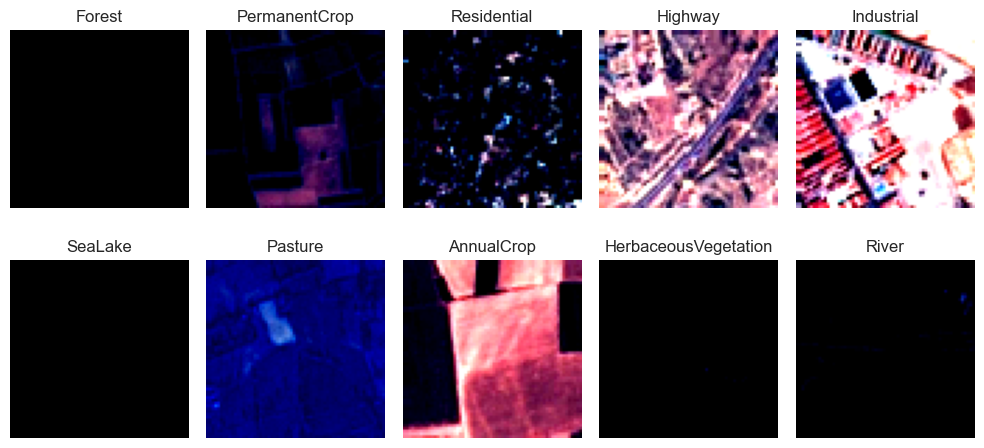

In [9]:
visualize_classes(train_loader, index_to_label)

In [10]:
dataset_managers = {
    'valid': valid_loader,
    'train': train_loader,
    'test': test_loader
}

print(f"Train set batches: {len(train_loader)}")
print(f"Validation set batches: {len(valid_loader)}")
print(f"Test set examples: {len(test_loader)}")

Train set batches: 148
Validation set batches: 169
Test set examples: 2700


## Labels distribution

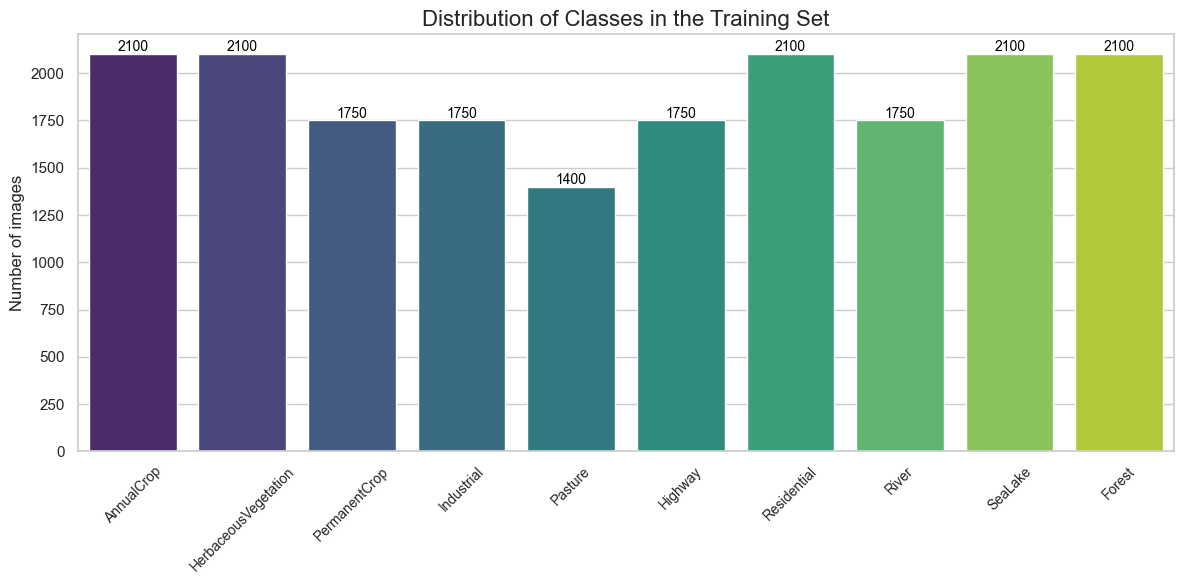

In [11]:
labels = train_dataset.data['Label'].values  # Assuming 'Label' is the column with labels

# Convert numerical labels to string names if necessary
label_names = [index_to_label[label] for label in labels]

sns.set(style="whitegrid")  # Set style
plt.figure(figsize=(12, 6))

# Adjusted according to the new API
ax = sns.countplot(x=label_names, hue=label_names, palette="viridis", legend=False)

#plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.title('Distribution of Classes in the Training Set', fontsize=16)
plt.xticks(rotation=45, fontsize=10)

# Add the count above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()



# Model

In [12]:
# Use un-pretrained model
model = resnext50_32x4d()

# Replace the model head with the number of classes
num_classes = 10
model.fc = nn.Linear(2048, num_classes) 
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

# Training model from Scratch

In [16]:
project_name = "EuroSAT"
model_name = "ResNeXt"
models_path = "C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/"

In [16]:
epochs = 200
lr = 0.0001
patience = 10

run = wandb.init(
    # Set the project where this run will be logged
    project=project_name,
    name=model_name,
    notes="ResNeXt from scratch",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": train_batch,
        "patience": patience
    })

loss_i, loss_val_i = train_model(model=model, epochs=epochs, 
                                 train_loader=train_loader,
                                 valid_loader=valid_loader,
                                 lr=lr, patience=patience, device=DEVICE)

Starting training with early stopping patience of 10
Each epoch has 148 steps.

Epoch: 1...
Step: 21/148 Loss: 2.0399265229701995
Step: 41/148 Loss: 1.5919701695442199
Step: 61/148 Loss: 1.3808097302913667
Step: 81/148 Loss: 1.2965233683586121
Step: 101/148 Loss: 1.1559630662202836
Step: 121/148 Loss: 1.1466937154531478
Step: 141/148 Loss: 1.0832303315401077
Validation Loss: 0.9997 Accuracy: 0.6326
Epoch duration: 47.08s

Epoch: 2...
Step: 21/148 Loss: 1.1910386353731155
Step: 41/148 Loss: 1.1818361312150956
Step: 61/148 Loss: 1.053282654285431
Step: 81/148 Loss: 1.0950180411338806
Step: 101/148 Loss: 1.0097550928592682
Step: 121/148 Loss: 0.9802216529846192
Step: 141/148 Loss: 0.9434802740812301
Validation Loss: 0.8849 Accuracy: 0.6744
Epoch duration: 41.48s

Epoch: 3...
Step: 21/148 Loss: 0.8920267790555954
Step: 41/148 Loss: 0.7784149706363678
Step: 61/148 Loss: 0.8535154014825821
Step: 81/148 Loss: 0.8471200436353683
Step: 101/148 Loss: 0.8738560199737548
Step: 121/148 Loss: 0.7187

Step: 81/148 Loss: 0.1616258930414915
Step: 101/148 Loss: 0.15702563859522342
Step: 121/148 Loss: 0.16612412184476852
Step: 141/148 Loss: 0.18357850164175032
Validation Loss: 0.5928 Accuracy: 0.8319
Epoch duration: 38.94s

Epoch: 25...
Step: 21/148 Loss: 0.14550518840551377
Step: 41/148 Loss: 0.14570321142673492
Step: 61/148 Loss: 0.20643062554299832
Step: 81/148 Loss: 0.19618794843554496
Step: 101/148 Loss: 0.19187207221984864
Step: 121/148 Loss: 0.16010811291635035
Step: 141/148 Loss: 0.20397456493228674
Validation Loss: 0.6845 Accuracy: 0.8181
Epoch duration: 39.31s

Epoch: 26...
Step: 21/148 Loss: 0.1785009354352951
Step: 41/148 Loss: 0.12585484869778157
Step: 61/148 Loss: 0.1607770062983036
Step: 81/148 Loss: 0.17541728168725967
Step: 101/148 Loss: 0.14921725280582904
Step: 121/148 Loss: 0.1505738850682974
Step: 141/148 Loss: 0.16958659887313843
Validation Loss: 0.5898 Accuracy: 0.8228
Epoch duration: 38.95s

Epoch: 27...
Step: 21/148 Loss: 0.14798597302287816
Step: 41/148 Loss: 0

## Save model

In [17]:
# Create models directory
os.makedirs(models_path, exist_ok=True)

# 2. Create model save path
model_save_path = os.path.join(models_path, model_name + ".pth")

# 3. Save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models\ResNeXt.pth


In [18]:
# Save the loss data in a file
with open(f"{models_path}/loss_{model_name}.txt", "w") as file:
    file.write(f"loss_i: {loss_i}\n")
    file.write(f"loss_val_i: {loss_val_i}\n")

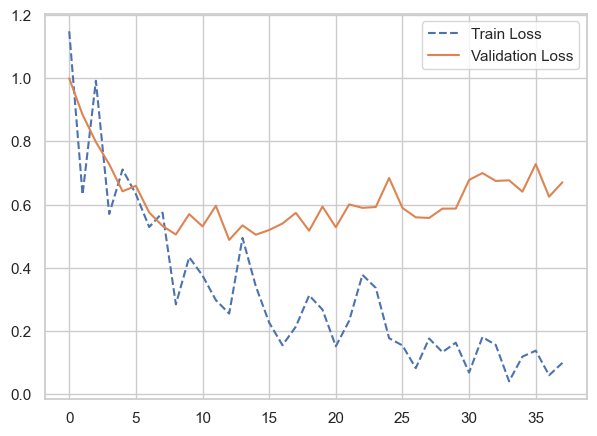

In [19]:
plt.figure(figsize=(7,5))
# Use a dashed line for the training loss, and add markers
plt.plot(loss_i, label="Train Loss", linestyle='--', alpha=1.0)

# Use a solid line for the validation loss
plt.plot(loss_val_i, label="Validation Loss", linestyle='-', alpha=1.0)
plt.legend()
plt.show()

# Evaluate model

In [20]:
# Call this function before evaluating your model to remove any wandb hook
#remove_wandb_hooks(model)

## Load best model

In [17]:
# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
model_save_path = models_path + f"{model_name}.pth"
print(f"Loading model {model_save_path}")
model.load_state_dict(torch.load(f = model_save_path))

Loading model C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/ResNeXt.pth


<All keys matched successfully>

In [18]:
evaluate_test_set(model, test_loader, DEVICE, index_to_label=index_to_label)

                      precision    recall  f1-score   support

          AnnualCrop      0.816     0.887     0.850       300
              Forest      0.932     0.910     0.921       300
HerbaceousVegetation      0.843     0.717     0.775       300
             Highway      0.702     0.632     0.665       250
          Industrial      0.928     0.924     0.926       250
             Pasture      0.854     0.760     0.804       200
       PermanentCrop      0.715     0.792     0.751       250
         Residential      0.976     0.930     0.952       300
               River      0.738     0.824     0.779       250
             SeaLake      0.901     0.997     0.946       300

            accuracy                          0.843      2700
           macro avg      0.840     0.837     0.837      2700
        weighted avg      0.845     0.843     0.842      2700



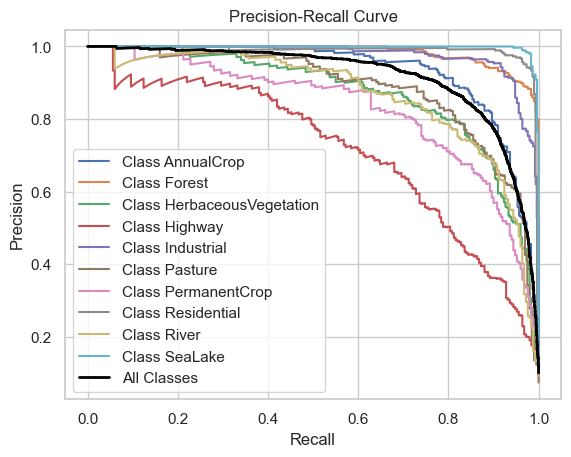

In [22]:
precision_recall_analysis(model, test_loader, DEVICE,
                          output_path=models_path,
                          model_name=model_name,
                          index_to_label=index_to_label)

In [23]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▇▅▄▅▄▃▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▄▅▅▆▇▇▆▇▇▇▇▇▇▇▇█▇█▇▇█▇▇█████████▇█▇
val_loss,█▆▅▄▃▃▂▂▁▂▂▂▁▂▁▁▂▂▁▂▂▃▂▂▄▂▂▂▂▂▄▄▄▄▃▄▃▃
epoch,37
step,5616
train_loss,0.12342
val_accuracy,0.82167
val_loss,0.67084


## Load the precision/recall curve and plot it

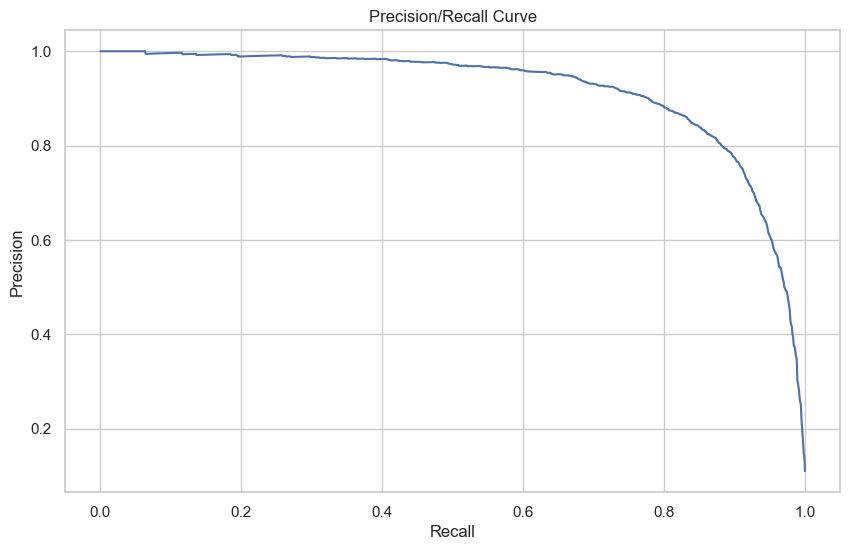

In [24]:
filename = f"{model_name}_precision_recall_values.json"
file_path = os.path.join(models_path, filename)

with open(file_path, 'r') as file:
    precision_recall_data = json.load(file)
    
all_classes_data = precision_recall_data['All Classes']

# Extract precision and recall values
precisions = all_classes_data.get('precision', [])
recalls = all_classes_data.get('recall', [])

# Create a DataFrame for plotting
df = pd.DataFrame({
    'Precision': precisions,
    'Recall': recalls
})

# Plotting the precision/recall curve
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Recall', y='Precision')
plt.title('Precision/Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

## Load trained model

In [25]:
# loaded_model = resnet50()
# num_classes = 10  
# loaded_model.fc = nn.Linear(2048, num_classes)

# # Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
# loaded_model.load_state_dict(torch.load(f = model_save_path))

## Clean-up

In [19]:
import gc

del model
torch.cuda.empty_cache()
gc.collect()


28305

# Now train the model with pre-trained weights

In [20]:
# Use pretrained model
model2 = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1)

# Replace the model head with the number of classes
num_classes = 10
model2.fc = nn.Linear(2048, num_classes) 
model2.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

## Train with pre-trained weights

In [21]:
model_name = "ResNeXt-Pretrained"

In [28]:
epochs = 200
lr = 0.0001
patience = 10

run = wandb.init(
    # Set the project where this run will be logged
    project=project_name,
    name=model_name,
    notes="ResNeXt pre-trained on ImageNet",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": train_batch,
        "patience": patience
    })

loss_i, loss_val_i = train_model(model=model2, epochs=epochs, 
                                 train_loader=train_loader,
                                 valid_loader=valid_loader,
                                 lr=lr, patience=patience, device=DEVICE)

Starting training with early stopping patience of 10
Each epoch has 148 steps.

Epoch: 1...
Step: 21/148 Loss: 1.0826613202691078
Step: 41/148 Loss: 0.24282054156064986
Step: 61/148 Loss: 0.16034574769437313
Step: 81/148 Loss: 0.13405735716223716
Step: 101/148 Loss: 0.13199343252927065
Step: 121/148 Loss: 0.12183475326746702
Step: 141/148 Loss: 0.11378947664052248
Validation Loss: 0.0862 Accuracy: 0.9711
Epoch duration: 40.17s

Epoch: 2...
Step: 21/148 Loss: 0.09323199174832553
Step: 41/148 Loss: 0.17263044156134127
Step: 61/148 Loss: 0.13761790934950113
Step: 81/148 Loss: 0.09198150867596269
Step: 101/148 Loss: 0.1071103261783719
Step: 121/148 Loss: 0.1312303852289915
Step: 141/148 Loss: 0.1535368710756302
Validation Loss: 0.0948 Accuracy: 0.9709
Epoch duration: 38.82s

Epoch: 3...
Step: 21/148 Loss: 0.06215263637714088
Step: 41/148 Loss: 0.05299822443630546
Step: 61/148 Loss: 0.05651888822903857
Step: 81/148 Loss: 0.05561315277591348
Step: 101/148 Loss: 0.05162237919867039
Step: 121/

## Save model

In [29]:
# Create models directory
os.makedirs(models_path, exist_ok=True)

# 2. Create model save path
model_save_path = os.path.join(models_path, model_name + ".pth")

# 3. Save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model2.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models\ResNeXt-Pretrained.pth


In [30]:
# Save the loss data in a file
with open(f"{models_path}/loss_{model_name}.txt", "w") as archivo:
    archivo.write(f"loss_i: {loss_i}\n")
    archivo.write(f"loss_val_i: {loss_val_i}\n")

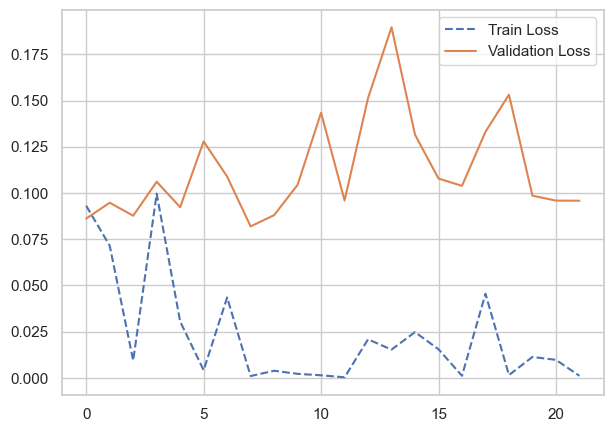

In [31]:
plt.figure(figsize=(7,5))
# Use a dashed line for the training loss, and add markers
plt.plot(loss_i, label="Train Loss", linestyle='--', alpha=1.0)

# Use a solid line for the validation loss
plt.plot(loss_val_i, label="Validation Loss", linestyle='-', alpha=1.0)
plt.legend()
plt.show()

# Evaluate model

In [32]:
# Call this function before evaluating your model to remove any wandb hook
#remove_wandb_hooks(model)

## Load best model

In [22]:
# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
model_save_path = models_path + f"{model_name}.pth"
print(f"Loading model {model_save_path}")
model2.load_state_dict(torch.load(f = model_save_path))

Loading model C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/ResNeXt-Pretrained.pth


<All keys matched successfully>

In [23]:
evaluate_test_set(model2, test_loader, DEVICE, index_to_label=index_to_label)

                      precision    recall  f1-score   support

          AnnualCrop      0.987     0.980     0.983       300
              Forest      0.980     0.993     0.987       300
HerbaceousVegetation      0.976     0.963     0.970       300
             Highway      0.976     0.992     0.984       250
          Industrial      0.996     0.972     0.984       250
             Pasture      0.995     0.955     0.974       200
       PermanentCrop      0.956     0.960     0.958       250
         Residential      0.987     1.000     0.993       300
               River      0.957     0.988     0.972       250
             SeaLake      1.000     0.997     0.998       300

            accuracy                          0.981      2700
           macro avg      0.981     0.980     0.980      2700
        weighted avg      0.981     0.981     0.981      2700



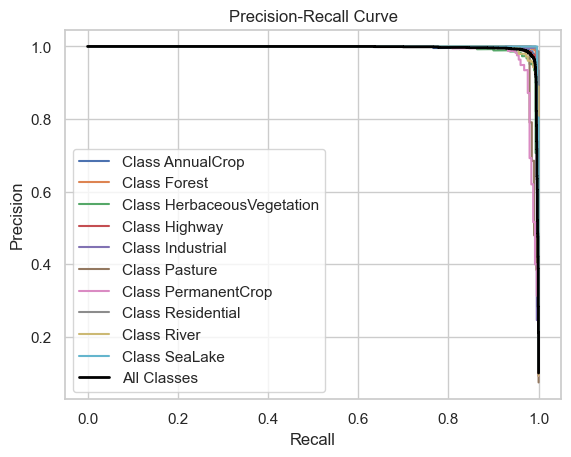

In [34]:
precision_recall_analysis(model2, test_loader, DEVICE,
                          output_path=models_path,
                          model_name=model_name,
                          index_to_label=index_to_label)

In [35]:
wandb.finish()

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▅▄▄▂▂▃▂▂▁▃▁▂▂▂▁▂▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▁
val_accuracy,▆▆▇▆▇▅▇██▇▆█▆▁▅▇▇▇▆█▇█
val_loss,▁▂▁▃▂▄▃▁▁▂▅▂▆█▄▃▂▄▆▂▂▂
epoch,21
step,3248
train_loss,0.00916
val_accuracy,0.97852
val_loss,0.09582


In [24]:
del model2
torch.cuda.empty_cache()
gc.collect()

17